# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import pandas as pd


In [2]:
data = pd.read_csv('train.csv')


In [3]:
data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [4]:
data.isna().any()


id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [5]:
data = data.fillna('')
data.isna().any(axis=None)


False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [6]:
print(f'Доля подтвержденных катастроф: {data["target"].mean()}')


Доля подтвержденных катастроф: 0.4296597924602653


In [7]:
top_keywords = data['keyword'].value_counts()[:10]
top_keywords


               61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: keyword, dtype: int64

In [8]:
confirmed_cases = data.groupby('keyword')['target'].mean().filter(
    items=top_keywords.index, axis=0)
confirmed_cases


keyword
               0.688525
fatalities     0.577778
deluge         0.142857
armageddon     0.119048
sinking        0.195122
damage         0.463415
harm           0.097561
body%20bags    0.024390
evacuate       0.625000
fear           0.125000
Name: target, dtype: float64

(-0.008816473410635746, 1.0)

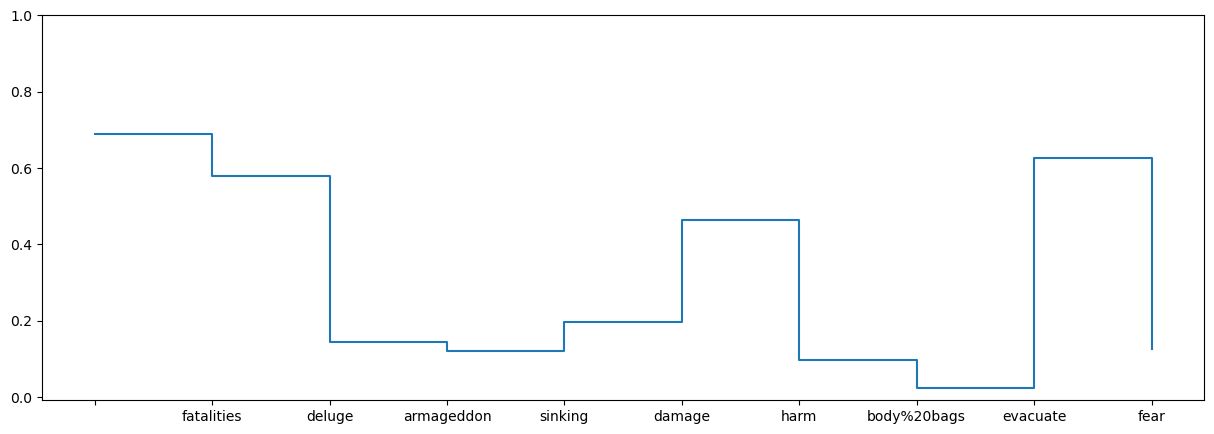

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.step(confirmed_cases.index, confirmed_cases, where='post')
plt.ylim(top=1)


> О первой категории ничего скааать нельзя, так как это пропущенные значения и там может быть что угодно. Тем не менее подтвержденных случаев в ней больше всего   
> Наиболее выделяются из оставшихся ключевых слов `evacuate`, `fatalities` и `damage`. Высокий уровень подтвержденных случаев скорее всего связан с тем, что эти слова очень редко встречаются вне контекста катастроф и чрезвычайных ситуаций в отличии например от `fear` или `sinking`

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [10]:
data['text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']
data.drop(columns=['id', 'keyword', 'location'], inplace=True)
data


,text,target
0,Our Deeds are the Reason of this #earthquake...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' ar...,1
3,"13,000 people receive #wildfires evacuation ...",1
4,Just got sent this photo from Ruby #Alaska a...,1
...,...,...
7608,Two giant cranes holding a bridge collapse i...,1
7609,@aria_ahrary @TheTawniest The out of control...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. h...,1
7611,Police investigating after an e-bike collide...,1


In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_vec = cv.fit_transform(train['text'])
train_vec.shape


(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [13]:
from string import punctuation

def analyse(cv):
    cnt_numbers = 0
    cnt_punctuation = 0
    cnt_athash = 0
    for word in cv.vocabulary_:
        cnt_numbers += any(map(str.isdigit, word))
        cnt_punctuation += any(map(lambda x: x in punctuation, word))
        cnt_athash += int(word[0] in '@#')

    print(f'Слова с цифрами: {cnt_numbers}')
    print(f'Слова с пунктуацией: {cnt_punctuation}')
    print(f'Хэштеги и упоминания: {cnt_athash}')


In [14]:
analyse(cv)

Слова с цифрами: 3812
Слова с пунктуацией: 315
Хэштеги и упоминания: 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [15]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

cv_twt = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
train_vec_nltk = cv_twt.fit_transform(train['text'])
train_vec_nltk.shape


(5329, 19670)

In [16]:
analyse(cv_twt)

Слова с цифрами: 3939
Слова с пунктуацией: 7338
Хэштеги и упоминания: 3149


In [17]:
s = '#war @elonmusk annihilated USA One thing for sure-God has promised Israel will not be annihilated. But...the horror of Iran w/nukes. https://t.co/xn09Mx6sxy'
cv.fit_transform([s])
cv_twt.fit_transform([s])

print(cv.vocabulary_.keys())
print(cv_twt.vocabulary_.keys())

dict_keys(['war', 'elonmusk', 'annihilated', 'usa', 'one', 'thing', 'for', 'sure', 'god', 'has', 'promised', 'israel', 'will', 'not', 'be', 'but', 'the', 'horror', 'of', 'iran', 'nukes', 'https', 'co', 'xn09mx6sxy'])
dict_keys(['#war', '@elonmusk', 'annihilated', 'usa', 'one', 'thing', 'for', 'sure-god', 'has', 'promised', 'israel', 'will', 'not', 'be', '.', 'but', '...', 'the', 'horror', 'of', 'iran', 'w', '/', 'nukes', 'https://t.co/xn09mx6sxy'])


> Здесь для демонстрации приведен чуть модифицированный твит из нашего датасета. Дефолтный токенайзер попросту выкинул практически все с намеком на пунктуацию, включая хэштеги и упоминания, поэтому мы их и не нашли.   
> Новый же токенайзер оставляет и хэштеги, и упоминания, и ссылки, и другую пунктуацию, поэтому и в целом фич у нас больше, и различной пунктуации мы нашли больше.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')


def custom_tokenizer(s: str):
    vec = TweetTokenizer(preserve_case=False).tokenize(s)
    vec = filter(lambda w: None != re.search(
        f'^#?[a-z]*$|^[{punctuation}]*[()]+[{punctuation}]*$', w), vec)
    vec = filter(lambda w: w not in stopwords.words('english'), vec)
    
    stemmer = SnowballStemmer('english')
    vec = [stemmer.stem(x) for x in vec]
    return vec


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikitasigal/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
for s in train['text'][:10]:
    print(custom_tokenizer(s))


['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


def test_vectorizer(train: pd.DataFrame, test: pd.DataFrame, vectorizer: callable, max_iter=1000):
    train_vec = vectorizer.fit_transform(train['text'])
    test_vec = vectorizer.transform(test['text'])
    if hasattr(vectorizer, 'vocabulary_'):
        print(f'Number of features: {len(vectorizer.vocabulary_)}')

    lg = LogisticRegression(max_iter=max_iter).fit(train_vec, train['target'])

    print(
        f"Train F1-score: {f1_score(train['target'], lg.predict(train_vec))}")
    print(f"Test F1-score: {f1_score(test['target'], lg.predict(test_vec))}")


In [21]:
test_vectorizer(train, test, CountVectorizer(tokenizer=custom_tokenizer))


Number of features: 10482
Train F1-score: 0.9521264751725673
Test F1-score: 0.752953813104189


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
test_vectorizer(train, test, TfidfVectorizer(tokenizer=custom_tokenizer))


Number of features: 10482
Train F1-score: 0.8424753867791844
Test F1-score: 0.7422222222222221


> По сравнению с [CountVectorizer](#задание-8-1-балл) стало хуже, но незначительно. Возможно множитель IDF добавил важности некоторым словам, которые в реальности большой смысловой нагрузки не несут, но встречаются очень редко. В конце концов документами являются реальные твиты, а там могут быть и очепятки, и слэнг, и еще бог весть что..

In [23]:
test_vectorizer(train, test, TfidfVectorizer(
    tokenizer=custom_tokenizer, max_df=0.9))


Number of features: 10482
Train F1-score: 0.8424753867791844
Test F1-score: 0.7422222222222221


> Число фич не изменилось, а значит DF ни одной из них не превышает 90%. Качество, очевидно, также не изменилось.

In [24]:
test_vectorizer(train, test, TfidfVectorizer(
    tokenizer=custom_tokenizer, min_df=0.0002, max_df=0.9))


Number of features: 4523
Train F1-score: 0.8251455180442374
Test F1-score: 0.7466666666666668


> Путем тяжелых математических операций (минута ручного бинарного поиска) удалось выяснить, что больше чем у половины слов DF меньше чем 0.02 процента, что кстати подтверждает гипотезу о большом количестве редких слов. После отсечения качество немного улучшается, но все еще не достигает уровня обычного [CountVectorizer](#задание-8-1-балл)

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [25]:
from sklearn.feature_extraction.text import HashingVectorizer

test_vectorizer(train, test, HashingVectorizer(
    tokenizer=custom_tokenizer, n_features=5000))


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train F1-score: 0.7992547741034001
Test F1-score: 0.7190635451505016


> Качество стало еще хуже. Вспомним, что у [CountVectorizer](#задание-8-1-балл) было `10482` фич. Сокращая количество фич в 2 раза, причем рандомно, получить что-то хорошее довольно трудно. Возвращаясь к тому, что это твиттер и большинство слов очень редкие, получившиеся суммы фич вряд-ли несут адекватную нагрузку. Соответсвенно и делать на основе таких признаков предсказания становится значительно труднее.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

> Начнем с того, что и обычный [CountVectorizer](#задание-8-1-балл) уже справляется с задаей, выдавая `~0.753` на тестовых данных, поэтому попробуем добиться хотя бы `0.76`   

> После долгих экспериментов с включением и выключением фильтров, различными токенайзерами, применением лемминизации и чтением твитов получилась функция `opt_tokenizer()`   
> Что мы в ней делаем:   
> 1. Ссылки. Наш старый `custom_tokenizer` попросту выбрасывает их, так как они содержат пунктуацию. В то же время просто оставлять в оригинале (как это делает `TweetTokenizer`) тоже не вариант, так как все ссылки уникальны, но при этом информацию о содержимом не несут. Тем не менее, наличие или отсутсвие ссылок в твите может иметь для нас ценность, поэтому все ссылки мы просто замением на слово `link` (а лучше на что-то такое, что не встретится нам в качестве реального токена в тексте)   
> 2. Пробелы. В столбце `keyword` пробелы заменены на `%20`. Нам нет никакого смысла рассматривать подобные записи как один склеенный токен, поэтому мы их разбиваем.   
> 3. Опускаем все буквы, тут и так понятно.   
> 4. Токенизация. Путем экспериментов был выбран `TreebankWordTokenizer`. По не до конца понятному мне принципу, он разделяет слова и пунктуцию, но не везде (пример ниже). Фич при этом, логично, становится больше, но они видимо все-таки несут некоторую информацию.   
> 5. Фильтры. А фильтров никаких нет, даже на стоп-слова. Опять же, фич больше, но мы надеемся, что они дадут нам дополнительную информацию.
> 6. Стэмминг. Неожиданно, при попытке применить применить лемминизацию nltk качество заментно упало. С чем это связано я даже не берусь сказать, так что просто оставим все как есть.
> В конечном итоге получаем `0.765`, прирост на `0.012`. Не так уж и много, но все же прирост. Вопрос лишь в том, стоил ли такой прирост затраченных усилий...

In [26]:
from nltk.tokenize import TreebankWordTokenizer

def opt_tokenizer(s: str):
    s = re.sub('https?://t.co/[a-zA-Z0-9]*', 'link', s)
    s = s.replace('%20', ' ')
    s = s.lower()

    vec = TreebankWordTokenizer().tokenize(s)

    stemmer = SnowballStemmer('english')
    vec = [stemmer.stem(w) for w in vec]
    return vec


In [27]:
test_vectorizer(train, test, CountVectorizer(tokenizer=opt_tokenizer), 10000)


Number of features: 14612
Train F1-score: 0.9663865546218487
Test F1-score: 0.7652838427947598


In [28]:
s = '#war @elonmusk annihilated USA One thing for sure-God has promised Israel will not be annihilated. But...the horror of Iran w/nukes. https://t.co/xn09Mx6sxy'
print(custom_tokenizer(s))
print(opt_tokenizer(s))



['#war', 'annihil', 'usa', 'one', 'thing', 'promis', 'israel', 'annihil', 'horror', 'iran', 'w', 'nuke']
['#', 'war', '@', 'elonmusk', 'annihil', 'usa', 'one', 'thing', 'for', 'sure-god', 'has', 'promis', 'israel', 'will', 'not', 'be', 'annihilated.', 'but', '...', 'the', 'horror', 'of', 'iran', 'w/nukes.', 'link']
